In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
import random
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import utils
import h5py
'''
Based on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb
See: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf
for possible implementation into FPGA
'''

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'\nBased on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb\nSee: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf\nfor possible implementation into FPGA\n'

In [2]:
def plot_loss(data, title,yscale="linear"):     
    """ Plots the training and validation loss yscale can be: linear,log,symlog """
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history["loss"])#, linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history["val_loss"])#, linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"])#, loc="upper right", frameon=False)
    plt.yscale(yscale)
    plt.show();

In [378]:
class Pulse:
    '''
    A class that generates a Pulse that includes both Cerenkov and Scintillation Pulse. The pulse is randomly generated 
    through the use of a probability density function that is generated by the given parameters.
    The pulse has 512 samples and is identifiable by 3 parameters:
        1) ratio: If ratio is positive, it is the ratio of the Area of Cernekov:Area of Scintillation. 
                  If ratio is negative, it is the ratio of the Area of Scintillation:Area of Cerenkov
                
        This is altered by changing the height of the Cerenkov pulse (Cerenkov Radiation).
        
        
        2) separation: Time between the two pulses
       
    '''
    
    
    
    def __init__(self, photoelectrons, ratio, scint_decay):
        self.start=10
        self.rise=0.05
        self.cerenkov_decay=2.5
        self.scint_decay=scint_decay
        
        self.end_time=500
        self.timestep=0.1
        self.t=t=np.arange(0,self.end_time,self.timestep)
        self.bin_number=100
        

        if ratio>0:
            self.ratio=ratio
        else:
            self.ratio=-(1/ratio)
            
        self.photoelectrons=photoelectrons
        self.cerenkov_strength=self.ratio
        #self.cerenkov_percent=self.ratio/(self.ratio+1)
        #self.scint_percent=1/(self.ratio+1)
 
    def cerenkov(self,t):
        return (1-np.exp(-((t-self.start)/self.rise)))*(np.exp(-((t-self.start)/self.cerenkov_decay)))

    def scintillation(self, t):
        return (1-np.exp(-((t-self.start)/self.rise)))*(np.exp(-((t-self.start)/self.scint_decay)))
    
    def cerenkov_scaled(self, t):
        cerenkov=self.cerenkov(t)
        norm=sp.integrate.quad(self.cerenkov, self.start, self.end_time)
        return (1/norm[0])*self.cerenkov_strength*cerenkov
    
    def scintillation_normalized(self, t):
        scint=self.scintillation(t)
        norm=sp.integrate.quad(self.scintillation, self.start, self.end_time)
        return (1/norm[0])*scint


    def pulse_func_helper(self, time):
        if time<self.start:
            return 0
        else:
            return self.cerenkov_scaled(time) + self.scintillation_normalized(time) 
    
    
    def pulse_func(self, t):
        pulse=[]
                        
        for time in t:
            pulse.append(self.pulse_func_helper(time))
        return np.asarray(pulse)


    def randomValues(self,number):
        val=[]
        for x in range(number):
            val.append(random.random())
        return val

    
    def final_pdf(self, t):
        radiation=self.pulse_func(t)
        norm=sp.integrate.quad(self.pulse_func_helper, 0, self.end_time)
        return (1/norm[0])*radiation

    def final_cdf(self, t):
        prob=self.final_pdf(t)
        return np.cumsum(prob)*self.timestep

    def final_distribution(self):
        cumul=self.final_cdf(self.t)
        hits=self.photoelectrons
        #print(hits)
        rand=self.randomValues(hits)
        #print(rand)
        interp=sp.interpolate.interp1d(cumul,self.t, fill_value="extrapolate")
        vals=interp(rand)
        #print(vals)
        return vals
    
    def histogram_generator(self):
        data=self.final_distribution()
        hist, bin_edges=np.histogram(data, bins=self.bin_number, range=(0,self.end_time))
        print(bin_edges)
        return hist
    
    def output(self):
        '''
        Returns Histogram data and percent of area under 
        '''
        self.cerenkov_area=sp.integrate.quad(self.cerenkov_scaled, self.start, self.end_time)
        self.scint_area=sp.integrate.quad(self.scintillation_normalized, self.start, self.end_time)
        
        self.cerenkov_percent=(self.cerenkov_area[0])/(self.cerenkov_area[0]+self.scint_area[0])
        self.scint_percent=(self.scint_area[0])/(self.cerenkov_area[0]+self.scint_area[0])
        return self.histogram_generator(), self.cerenkov_percent, self.scint_percent



In [133]:
class PulseLibrary:
    '''
    Creates a list of pulses with the attached ratio.
    labels has form of ratioXXXscint_decayXXeventXX
    '''
    
    def __init__(self, seed, name, eventsperexperiment, photoelectrons,ratios=[1],scint_decays=[50]):
        np.random.seed(seed)
        self.name=name +'.hdf5'
        self.scint_decays=scint_decays
        self.ratios=ratios
        self.photoelectrons=photoelectrons
        self.eventsperexperiment=eventsperexperiment
        self.labels=[]
        self.pulses=[]
        self.inputs=[]
        self.outputs=[]
        
        
        
        file=h5py.File(self.name, 'w')
        
        for ratio in self.ratios:
            for scint_decay in self.scint_decays:
                pulse=Pulse(self.photoelectrons, ratio, scint_decay)
                
                group_name="ratio"+str(ratio)+"scintdecay"+str(scint_decay)
                
                group = file.create_group(group_name)
                
                for i in range(eventsperexperiment):
                    
                    self.pulses.append(pulse)
                    ins, out1, out2=pulse.output()
                    outs=[out1, out2]
                    
                    
                    label="ratio"+str(ratio)+"scintdecay"+str(scint_decay)+"event"+str(i)
                    self.labels.append(label)
                    self.inputs.append(ins)
                    self.outputs.append(outs)
                    
                    subgroup=group.create_group(label)
                    
                    
                    d1 = subgroup.create_dataset(label+'input', data=ins)
                    d2 = subgroup.create_dataset(label+'output', data=outs)
                    
        
        file.close()
    
    def get_inputs(self):
        return np.asarray(self.inputs)
    
    def get_outputs(self):
        return np.asarray(self.outputs)
    
    def get_labels(self):
        return self.labels
    
    def get_pulses(self):
        return np.asarray(self.pulses)

In [134]:
def model_creator():
    model = Sequential()
    #model.add(Dense(50,  input_shape=(100,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(10,  input_shape=(100,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))
# Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def model_trainer(pulse_library):
    model=model_creator()
    file=h5py.File(pulse_library, 'r')
    X=[]
    Y=[]
    for groups in file.values():
        for subgroup in groups.values():
            for event in subgroup.values():
                if event.name[-5:]=="input":
                    X.append(event)
                elif event.name[-6:]=="output":
                    Y.append(event)
        
    X=np.asarray(X)
    Y=np.asarray(Y)
    Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=42)
    checkpointer = ModelCheckpoint(filepath='AE_random_best_model.hdf5',verbose=3, save_best_only=True)
    earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50 ,verbose=1, mode='auto')
    history=model.fit(Xtrain,Ytrain,epochs=300
                             ,verbose=1
                             ,validation_data=(Xval,Yval)
                             ,shuffle=True
                             ,callbacks=[checkpointer,earlystop])
    model.save("model.hdf5")
    return model, history

def model_verifier(pulse_library, model):
    file=h5py.File(pulse_library, 'r')
    X=[]
    Y=[]
    labels=[]
    for groups in file.values():
        tempX=[]
        tempY=[]
        templabels=[]
        for subgroup in groups.values():
            
            for event in subgroup.values():
                if event.name[-5:]=="input":
                    tempX.append(event)
                    templabels.append(event.name)
                elif event.name[-6:]=="output":
                    tempY.append(event)
        X.append(tempX)
        Y.append(tempY)
        labels.append(templabels)
            
    X=np.asarray(X)
    Y=np.asarray(Y)
    results=[]
    for x in X:
        prediction=model.predict(x)
        results.append(prediction)
    results=np.array(results)
    #results=model.predict(X)
    return results, Y, labels

In [7]:
training_seed=7
testing_seed=8

scint_decays=np.linspace(5,50,10)
train_library=PulseLibrary(training_seed,"VaryScintDecayOnlyTrainingLibrary", 50,1000, [1], scint_decays)
test_library=PulseLibrary(testing_seed,"VaryScintDecayOnlyTestingLibrary", 50,1000, [1], scint_decays)

C:\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:595: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [8]:
nn1_model,nn1_history=model_trainer('VaryScintDecayOnlyTrainingLibrary.hdf5')

Train on 400 samples, validate on 100 samples
Epoch 1/300
400/400 [==============================] - 1s 2ms/step - loss: 26.2227 - val_loss: 7.0827

Epoch 00001: val_loss improved from inf to 7.08266, saving model to AE_random_best_model.hdf5
Epoch 2/300
400/400 [==============================] - 0s 77us/step - loss: 3.1093 - val_loss: 1.0049

Epoch 00002: val_loss improved from 7.08266 to 1.00488, saving model to AE_random_best_model.hdf5
Epoch 3/300
400/400 [==============================] - 0s 75us/step - loss: 1.1027 - val_loss: 0.9740

Epoch 00003: val_loss improved from 1.00488 to 0.97403, saving model to AE_random_best_model.hdf5
Epoch 4/300
400/400 [==============================] - 0s 95us/step - loss: 0.8128 - val_loss: 0.5026

Epoch 00004: val_loss improved from 0.97403 to 0.50258, saving model to AE_random_best_model.hdf5
Epoch 5/300
400/400 [==============================] - 0s 77us/step - loss: 0.4904 - val_loss: 0.3799

Epoch 00005: val_loss improved from 0.50258 to 0.37

Epoch 82/300
400/400 [==============================] - 0s 75us/step - loss: 0.0053 - val_loss: 0.0063

Epoch 00082: val_loss improved from 0.00639 to 0.00628, saving model to AE_random_best_model.hdf5
Epoch 83/300
400/400 [==============================] - 0s 92us/step - loss: 0.0052 - val_loss: 0.0063

Epoch 00083: val_loss improved from 0.00628 to 0.00626, saving model to AE_random_best_model.hdf5
Epoch 84/300
400/400 [==============================] - 0s 127us/step - loss: 0.0052 - val_loss: 0.0062

Epoch 00084: val_loss improved from 0.00626 to 0.00622, saving model to AE_random_best_model.hdf5
Epoch 85/300
400/400 [==============================] - 0s 110us/step - loss: 0.0051 - val_loss: 0.0061

Epoch 00085: val_loss improved from 0.00622 to 0.00609, saving model to AE_random_best_model.hdf5
Epoch 86/300
400/400 [==============================] - 0s 122us/step - loss: 0.0050 - val_loss: 0.0061

Epoch 00086: val_loss improved from 0.00609 to 0.00605, saving model to AE_random_bes

Epoch 124/300
400/400 [==============================] - 0s 80us/step - loss: 0.0031 - val_loss: 0.0040

Epoch 00124: val_loss did not improve from 0.00403
Epoch 125/300
400/400 [==============================] - 0s 87us/step - loss: 0.0030 - val_loss: 0.0039

Epoch 00125: val_loss improved from 0.00403 to 0.00395, saving model to AE_random_best_model.hdf5
Epoch 126/300
400/400 [==============================] - 0s 120us/step - loss: 0.0030 - val_loss: 0.0039

Epoch 00126: val_loss improved from 0.00395 to 0.00391, saving model to AE_random_best_model.hdf5
Epoch 127/300
400/400 [==============================] - 0s 100us/step - loss: 0.0029 - val_loss: 0.0039

Epoch 00127: val_loss improved from 0.00391 to 0.00389, saving model to AE_random_best_model.hdf5
Epoch 128/300
400/400 [==============================] - 0s 117us/step - loss: 0.0029 - val_loss: 0.0038

Epoch 00128: val_loss improved from 0.00389 to 0.00385, saving model to AE_random_best_model.hdf5
Epoch 129/300
400/400 [======

400/400 [==============================] - 0s 96us/step - loss: 9.6100e-04 - val_loss: 0.0015

Epoch 00208: val_loss improved from 0.00159 to 0.00151, saving model to AE_random_best_model.hdf5
Epoch 209/300
400/400 [==============================] - 0s 80us/step - loss: 9.3667e-04 - val_loss: 0.0015

Epoch 00209: val_loss improved from 0.00151 to 0.00149, saving model to AE_random_best_model.hdf5
Epoch 210/300
400/400 [==============================] - 0s 110us/step - loss: 9.1798e-04 - val_loss: 0.0015

Epoch 00210: val_loss improved from 0.00149 to 0.00149, saving model to AE_random_best_model.hdf5
Epoch 211/300
400/400 [==============================] - 0s 110us/step - loss: 8.9645e-04 - val_loss: 0.0015

Epoch 00211: val_loss improved from 0.00149 to 0.00146, saving model to AE_random_best_model.hdf5
Epoch 212/300
400/400 [==============================] - 0s 95us/step - loss: 8.9182e-04 - val_loss: 0.0014

Epoch 00212: val_loss improved from 0.00146 to 0.00145, saving model to AE_


Epoch 00289: val_loss improved from 0.00053 to 0.00052, saving model to AE_random_best_model.hdf5
Epoch 290/300
400/400 [==============================] - 0s 95us/step - loss: 2.5872e-04 - val_loss: 5.2627e-04

Epoch 00290: val_loss did not improve from 0.00052
Epoch 291/300
400/400 [==============================] - 0s 90us/step - loss: 2.6133e-04 - val_loss: 5.2760e-04

Epoch 00291: val_loss did not improve from 0.00052
Epoch 292/300
400/400 [==============================] - 0s 97us/step - loss: 2.5374e-04 - val_loss: 5.0113e-04

Epoch 00292: val_loss improved from 0.00052 to 0.00050, saving model to AE_random_best_model.hdf5
Epoch 293/300
400/400 [==============================] - 0s 100us/step - loss: 2.4570e-04 - val_loss: 4.9779e-04

Epoch 00293: val_loss improved from 0.00050 to 0.00050, saving model to AE_random_best_model.hdf5
Epoch 294/300
400/400 [==============================] - 0s 120us/step - loss: 2.4174e-04 - val_loss: 4.8825e-04

Epoch 00294: val_loss improved from 

In [18]:
nn1_results, actual_values=model_verifier('VaryScintDecayOnlyTestingLibrary.hdf5',nn1_model)


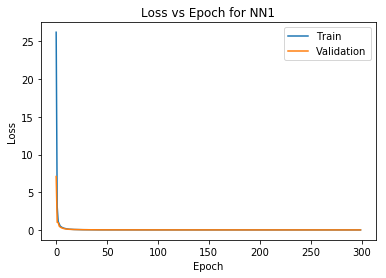

In [10]:
plot_loss(data=nn1_history,title="Loss vs Epoch for NN1",yscale='linear')

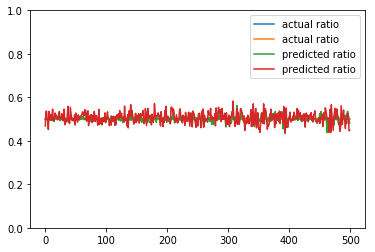

In [15]:
plt.plot(nn1_actual_values, label="actual ratio")
plt.plot(nn1_results, label="predicted ratio")
plt.ylim(0,1)
plt.legend()

In [17]:
#train_library=PulseLibrary(training_seed,"VaryRatioAndScintDecayTrainingLibrary", 50,1000, ratios, scint_decays)
#test_library=PulseLibrary(testing_seed,"VaryRatioAndScintDecay", 50,1000, ratios, scint_decays)

nn2_model,nn2_history=model_trainer('VaryRatioAndScintDecayTrainingLibrary.hdf5')


Train on 1440 samples, validate on 360 samples
Epoch 1/300
1440/1440 [==============================] - 0s 242us/step - loss: 4.6433 - val_loss: 0.2590

Epoch 00001: val_loss improved from inf to 0.25901, saving model to AE_random_best_model.hdf5
Epoch 2/300
1440/1440 [==============================] - 0s 54us/step - loss: 0.1393 - val_loss: 0.1031

Epoch 00002: val_loss improved from 0.25901 to 0.10311, saving model to AE_random_best_model.hdf5
Epoch 3/300
1440/1440 [==============================] - 0s 56us/step - loss: 0.1126 - val_loss: 0.0973

Epoch 00003: val_loss improved from 0.10311 to 0.09726, saving model to AE_random_best_model.hdf5
Epoch 4/300
1440/1440 [==============================] - 0s 65us/step - loss: 0.1096 - val_loss: 0.0949

Epoch 00004: val_loss improved from 0.09726 to 0.09485, saving model to AE_random_best_model.hdf5
Epoch 5/300
1440/1440 [==============================] - 0s 62us/step - loss: 0.1029 - val_loss: 0.0871

Epoch 00005: val_loss improved from 0.0


Epoch 00045: val_loss did not improve from 0.05556
Epoch 46/300
1440/1440 [==============================] - 0s 99us/step - loss: 0.0634 - val_loss: 0.0561

Epoch 00046: val_loss did not improve from 0.05556
Epoch 47/300
1440/1440 [==============================] - 0s 105us/step - loss: 0.0631 - val_loss: 0.0682

Epoch 00047: val_loss did not improve from 0.05556
Epoch 48/300
1440/1440 [==============================] - 0s 107us/step - loss: 0.0638 - val_loss: 0.0591

Epoch 00048: val_loss did not improve from 0.05556
Epoch 49/300
1440/1440 [==============================] - 0s 94us/step - loss: 0.0626 - val_loss: 0.0593

Epoch 00049: val_loss did not improve from 0.05556
Epoch 50/300
1440/1440 [==============================] - 0s 103us/step - loss: 0.0626 - val_loss: 0.0569

Epoch 00050: val_loss did not improve from 0.05556
Epoch 51/300
1440/1440 [==============================] - 0s 80us/step - loss: 0.0615 - val_loss: 0.0557

Epoch 00051: val_loss did not improve from 0.05556
Epo

1440/1440 [==============================] - 0s 74us/step - loss: 0.0569 - val_loss: 0.0492

Epoch 00095: val_loss did not improve from 0.04823
Epoch 96/300
1440/1440 [==============================] - 0s 92us/step - loss: 0.0557 - val_loss: 0.0494

Epoch 00096: val_loss did not improve from 0.04823
Epoch 97/300
1440/1440 [==============================] - 0s 100us/step - loss: 0.0554 - val_loss: 0.0506

Epoch 00097: val_loss did not improve from 0.04823
Epoch 98/300
1440/1440 [==============================] - 0s 105us/step - loss: 0.0558 - val_loss: 0.0515

Epoch 00098: val_loss did not improve from 0.04823
Epoch 99/300
1440/1440 [==============================] - 0s 89us/step - loss: 0.0570 - val_loss: 0.0530

Epoch 00099: val_loss did not improve from 0.04823
Epoch 100/300
1440/1440 [==============================] - 0s 96us/step - loss: 0.0569 - val_loss: 0.0604

Epoch 00100: val_loss did not improve from 0.04823
Epoch 101/300
1440/1440 [==============================] - 0s 115us/

Epoch 146/300
1440/1440 [==============================] - 0s 90us/step - loss: 0.0490 - val_loss: 0.0478

Epoch 00146: val_loss did not improve from 0.04418
Epoch 147/300
1440/1440 [==============================] - 0s 106us/step - loss: 0.0502 - val_loss: 0.0426

Epoch 00147: val_loss improved from 0.04418 to 0.04265, saving model to AE_random_best_model.hdf5
Epoch 148/300
1440/1440 [==============================] - 0s 98us/step - loss: 0.0485 - val_loss: 0.0422

Epoch 00148: val_loss improved from 0.04265 to 0.04221, saving model to AE_random_best_model.hdf5
Epoch 149/300
1440/1440 [==============================] - 0s 104us/step - loss: 0.0487 - val_loss: 0.0404

Epoch 00149: val_loss improved from 0.04221 to 0.04039, saving model to AE_random_best_model.hdf5
Epoch 150/300
1440/1440 [==============================] - 0s 91us/step - loss: 0.0477 - val_loss: 0.0412

Epoch 00150: val_loss did not improve from 0.04039
Epoch 151/300
1440/1440 [==============================] - 0s 91us/

1440/1440 [==============================] - 0s 71us/step - loss: 0.0415 - val_loss: 0.0352

Epoch 00244: val_loss did not improve from 0.03473
Epoch 245/300
1440/1440 [==============================] - 0s 66us/step - loss: 0.0405 - val_loss: 0.0375

Epoch 00245: val_loss did not improve from 0.03473
Epoch 246/300
1440/1440 [==============================] - 0s 57us/step - loss: 0.0419 - val_loss: 0.0387

Epoch 00246: val_loss did not improve from 0.03473
Epoch 247/300
1440/1440 [==============================] - 0s 50us/step - loss: 0.0442 - val_loss: 0.0543

Epoch 00247: val_loss did not improve from 0.03473
Epoch 248/300
1440/1440 [==============================] - 0s 55us/step - loss: 0.0411 - val_loss: 0.0352

Epoch 00248: val_loss did not improve from 0.03473
Epoch 249/300
1440/1440 [==============================] - 0s 59us/step - loss: 0.0412 - val_loss: 0.0401

Epoch 00249: val_loss did not improve from 0.03473
Epoch 250/300
1440/1440 [==============================] - 0s 55us

In [178]:
nn2_results, nn2_actual_values, nn2_labels=model_verifier('VaryRatioAndScintDecayTestingLibrary.hdf5',nn2_model)

In [183]:
print(nn2_actual_values[0])
print(nn2_results[0])

[[0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]
 [0.00990099 0.99009901]


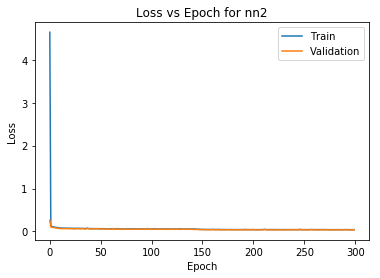

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [184]:
plot_loss(data=nn2_history,title="Loss vs Epoch for nn2",yscale='linear')
plt.figure()


In [46]:
print(nn2_labels)


[['/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event0/ratio-10scintdecay2.5event0input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event1/ratio-10scintdecay2.5event1input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event10/ratio-10scintdecay2.5event10input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event11/ratio-10scintdecay2.5event11input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event12/ratio-10scintdecay2.5event12input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event13/ratio-10scintdecay2.5event13input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event14/ratio-10scintdecay2.5event14input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event15/ratio-10scintdecay2.5event15input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event16/ratio-10scintdecay2.5event16input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event17/ratio-10scintdecay2.5event17input', '/ratio-100.0scintdecay2.5/ratio-10scintdecay2.5event18/ratio-10scintdecay2.5event

In [165]:


nn2_profile=2*(nn2_results-nn2_actual_values)/(nn2_results+nn2_actual_values)
nn2_profile=np.asarray(nn2_profile)
temp=[item[0] for item in nn2_profile]
print(nn2_profile[0])

[[ 1.89275194 -0.54031623]
 [ 1.89186616 -0.54315264]
 [ 1.8984387  -0.57782284]
 [ 1.8992026  -0.58217706]
 [ 1.91468997 -0.70590588]
 [ 1.90869786 -0.65775564]
 [ 1.88841108 -0.53060605]
 [ 1.91618836 -0.71439295]
 [ 1.92015885 -0.77006492]
 [ 1.90236231 -0.61852366]
 [ 1.91350908 -0.70891792]
 [ 1.9017561  -0.60468917]
 [ 1.91135786 -0.68106788]
 [ 1.90099645 -0.58978913]
 [ 1.90417845 -0.61452091]
 [ 1.89967246 -0.58418017]
 [ 1.90473289 -0.62353318]
 [ 1.90748355 -0.64123842]
 [ 1.9078111  -0.64517223]
 [ 1.90201813 -0.60561203]
 [ 1.91109098 -0.67050818]
 [ 1.90030359 -0.5835797 ]
 [ 1.90629989 -0.63585596]
 [ 1.89933423 -0.58497481]
 [ 1.90474627 -0.61874844]
 [ 1.90164011 -0.60336623]
 [ 1.91713027 -0.73883689]
 [ 1.90531357 -0.62372691]
 [ 1.90930799 -0.66095334]
 [ 1.90786932 -0.64587017]
 [ 1.87716242 -0.47478376]
 [ 1.90340933 -0.6155361 ]
 [ 1.89952567 -0.58530783]
 [ 1.89671622 -0.56881166]
 [ 1.898202   -0.58507035]
 [ 1.90575947 -0.613788  ]
 [ 1.90784496 -0.64936232]
 

In [166]:
nn2_profile_labels=[]
nn2_profile_cerenkov_mean=[]
nn2_profile_scintillation_mean=[]
nn2_profile_cerenkov_stdev=[]
nn2_profile_scintillation_stdev=[]
for i in range(len(nn2_profile)):
    #print(len([item[0] for item in nn2_profile[i]]))
    nn2_profile_cerenkov_mean.append(np.mean([item[0] for item in nn2_profile[i]]))
    nn2_profile_cerenkov_stdev.append(np.std([item[0] for item in nn2_profile[i]]))
    nn2_profile_scintillation_mean.append(np.mean([item[1] for item in nn2_profile[i]]))
    nn2_profile_scintillation_stdev.append(np.std([item[1] for item in nn2_profile[i]]))
    nn2_profile_labels.append(nn2_labels[i][0])

    


In [167]:
nn2_profile_labels_clean=[]
for label in nn2_profile_labels:
    index=label.find('/',2)
    print(label[1:index])
    nn2_profile_labels_clean.append(label[1:index])

ratio-100.0scintdecay2.5
ratio-20.0scintdecay2.5
ratio-60.0scintdecay2.5
ratio0.016666666666666666scintdecay121.0
ratio0.016666666666666666scintdecay160.5
ratio0.016666666666666666scintdecay200.0
ratio0.016666666666666666scintdecay42.0
ratio0.016666666666666666scintdecay81.5
ratio0.01scintdecay121.0
ratio0.01scintdecay160.5
ratio0.01scintdecay200.0
ratio0.01scintdecay42.0
ratio0.01scintdecay81.5
ratio0.05scintdecay121.0
ratio0.05scintdecay160.5
ratio0.05scintdecay200.0
ratio0.05scintdecay42.0
ratio0.05scintdecay81.5
ratio100.0scintdecay121.0
ratio100.0scintdecay160.5
ratio100.0scintdecay2.5
ratio100.0scintdecay200.0
ratio100.0scintdecay42.0
ratio100.0scintdecay81.5
ratio20.0scintdecay121.0
ratio20.0scintdecay160.5
ratio20.0scintdecay2.5
ratio20.0scintdecay200.0
ratio20.0scintdecay42.0
ratio20.0scintdecay81.5
ratio60.0scintdecay121.0
ratio60.0scintdecay160.5
ratio60.0scintdecay2.5
ratio60.0scintdecay200.0
ratio60.0scintdecay42.0
ratio60.0scintdecay81.5


In [168]:
nn2_profile_labels_clean_reordered=[]
for label in nn2_profile_labels_clean:
    if '-' in label:
        minus_location=label.find('-')
        s_location=label.find('s')
        ratio=-1/float(label[minus_location:s_location])
        label=label[:minus_location]+str(ratio)+label[s_location:]
    nn2_profile_labels_clean_reordered.append(label)
        


In [169]:
for label in nn2_profile_labels_clean_reordered:
    print(label)

ratio0.01scintdecay2.5
ratio0.05scintdecay2.5
ratio0.016666666666666666scintdecay2.5
ratio0.016666666666666666scintdecay121.0
ratio0.016666666666666666scintdecay160.5
ratio0.016666666666666666scintdecay200.0
ratio0.016666666666666666scintdecay42.0
ratio0.016666666666666666scintdecay81.5
ratio0.01scintdecay121.0
ratio0.01scintdecay160.5
ratio0.01scintdecay200.0
ratio0.01scintdecay42.0
ratio0.01scintdecay81.5
ratio0.05scintdecay121.0
ratio0.05scintdecay160.5
ratio0.05scintdecay200.0
ratio0.05scintdecay42.0
ratio0.05scintdecay81.5
ratio100.0scintdecay121.0
ratio100.0scintdecay160.5
ratio100.0scintdecay2.5
ratio100.0scintdecay200.0
ratio100.0scintdecay42.0
ratio100.0scintdecay81.5
ratio20.0scintdecay121.0
ratio20.0scintdecay160.5
ratio20.0scintdecay2.5
ratio20.0scintdecay200.0
ratio20.0scintdecay42.0
ratio20.0scintdecay81.5
ratio60.0scintdecay121.0
ratio60.0scintdecay160.5
ratio60.0scintdecay2.5
ratio60.0scintdecay200.0
ratio60.0scintdecay42.0
ratio60.0scintdecay81.5


In [170]:
nn2_scint_decays=np.linspace(2.5,200,6)
nn2_ratios=np.linspace(-100,100,6)

In [173]:
nn2_profile_cerenkov_mean_reordered=[]
nn2_profile_cerenkov_stdev_reordered=[]
nn2_profile_scintillation_mean_reordered=[]
nn2_profile_scintillation_stdev_reordered=[]
nn2_profile_labels_clean_check=[]

for ratio in nn2_ratios:
    if ratio<0:
        ratio=-1/ratio
    cerenkov_mean_temp=[]
    cerenkov_stdev_temp=[]
    scintillation_mean_temp=[]
    scintillation_stdev_temp=[]
    label_temp=[]
    while len(cerenkov_mean_temp)<6:
        for scint_decay in nn2_scint_decays:

            for label in nn2_profile_labels_clean_reordered:
                if str(ratio)+"s" in label and str(scint_decay) in label:
                    print(label)
                    
                    
                    index_num=nn2_profile_labels_clean_reordered.index(label)
                    cerenkov_mean_temp.append(nn2_profile_cerenkov_mean[index_num])
                    cerenkov_stdev_temp.append(nn2_profile_cerenkov_stdev[index_num])
                    scintillation_mean_temp.append(nn2_profile_scintillation_mean[index_num])
                    scintillation_stdev_temp.append(nn2_profile_scintillation_stdev[index_num])
                    
                    label_temp.append(label)
                    
    nn2_profile_cerenkov_mean_reordered.append(cerenkov_mean_temp)
    nn2_profile_cerenkov_stdev_reordered.append(cerenkov_stdev_temp)
    nn2_profile_scintillation_mean_reordered.append(scintillation_mean_temp)
    nn2_profile_scintillation_stdev_reordered.append(scintillation_stdev_temp)
    nn2_profile_labels_clean_check.append(label_temp)

    
                

ratio0.01scintdecay2.5
ratio0.01scintdecay42.0
ratio0.01scintdecay81.5
ratio0.01scintdecay121.0
ratio0.01scintdecay160.5
ratio0.01scintdecay200.0
ratio0.016666666666666666scintdecay2.5
ratio0.016666666666666666scintdecay42.0
ratio0.016666666666666666scintdecay81.5
ratio0.016666666666666666scintdecay121.0
ratio0.016666666666666666scintdecay160.5
ratio0.016666666666666666scintdecay200.0
ratio0.05scintdecay2.5
ratio0.05scintdecay42.0
ratio0.05scintdecay81.5
ratio0.05scintdecay121.0
ratio0.05scintdecay160.5
ratio0.05scintdecay200.0
ratio20.0scintdecay2.5
ratio20.0scintdecay42.0
ratio20.0scintdecay81.5
ratio20.0scintdecay121.0
ratio20.0scintdecay160.5
ratio20.0scintdecay200.0
ratio60.0scintdecay2.5
ratio60.0scintdecay42.0
ratio60.0scintdecay81.5
ratio60.0scintdecay121.0
ratio60.0scintdecay160.5
ratio60.0scintdecay200.0
ratio100.0scintdecay2.5
ratio100.0scintdecay42.0
ratio100.0scintdecay81.5
ratio100.0scintdecay121.0
ratio100.0scintdecay160.5
ratio100.0scintdecay200.0


In [174]:
print(nn2_profile_labels_clean_check)

[['ratio0.01scintdecay2.5', 'ratio0.01scintdecay42.0', 'ratio0.01scintdecay81.5', 'ratio0.01scintdecay121.0', 'ratio0.01scintdecay160.5', 'ratio0.01scintdecay200.0'], ['ratio0.016666666666666666scintdecay2.5', 'ratio0.016666666666666666scintdecay42.0', 'ratio0.016666666666666666scintdecay81.5', 'ratio0.016666666666666666scintdecay121.0', 'ratio0.016666666666666666scintdecay160.5', 'ratio0.016666666666666666scintdecay200.0'], ['ratio0.05scintdecay2.5', 'ratio0.05scintdecay42.0', 'ratio0.05scintdecay81.5', 'ratio0.05scintdecay121.0', 'ratio0.05scintdecay160.5', 'ratio0.05scintdecay200.0'], ['ratio20.0scintdecay2.5', 'ratio20.0scintdecay42.0', 'ratio20.0scintdecay81.5', 'ratio20.0scintdecay121.0', 'ratio20.0scintdecay160.5', 'ratio20.0scintdecay200.0'], ['ratio60.0scintdecay2.5', 'ratio60.0scintdecay42.0', 'ratio60.0scintdecay81.5', 'ratio60.0scintdecay121.0', 'ratio60.0scintdecay160.5', 'ratio60.0scintdecay200.0'], ['ratio100.0scintdecay2.5', 'ratio100.0scintdecay42.0', 'ratio100.0scintd

In [175]:
nn2_profile_cerenkov_mean_reordered=np.asarray(nn2_profile_cerenkov_mean_reordered)
nn2_profile_cerenkov_stdev_reordered=np.asarray(nn2_profile_cerenkov_stdev_reordered)
nn2_profile_scintillation_mean_reordered=np.asarray(nn2_profile_scintillation_mean_reordered)
nn2_profile_scintillation_stdev_reordered=np.asarray(nn2_profile_scintillation_stdev_reordered)

In [120]:
nn2_profile_stdev_reordered[0].shape

(6,)

[1.90428117 0.99138836 0.97086148 0.95258322 0.94462941 0.94810133]


Text(0,0.5,'Photostatistics Ratio')

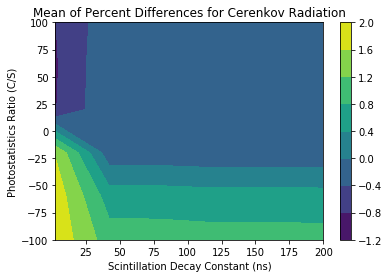

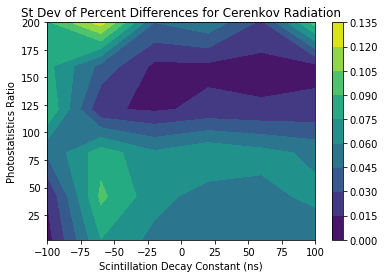

In [301]:
plot=plt.contourf(nn2_scint_decays,nn2_ratios, nn2_profile_cerenkov_mean_reordered)
#plt.clabel(plot, plot.levels, inline=True,  fontsize=10)
plt.colorbar()
plt.title("Mean of Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")

plt.figure()
plt.contourf(nn2_ratios, nn2_scint_decays, nn2_profile_cerenkov_stdev_reordered)
plt.colorbar()
plt.title("St Dev of Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio")

Text(0,0.5,'Photostatistics Ratio')

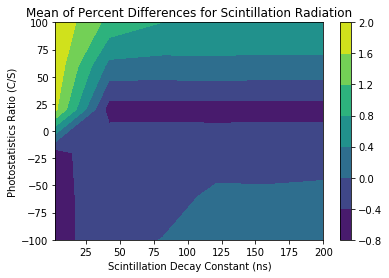

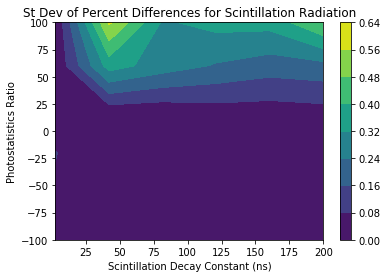

In [252]:

plot=plt.contourf(nn2_scint_decays,nn2_ratios, nn2_profile_scintillation_mean_reordered,extend="neither")
#plt.clabel(plot, plot.levels, inline=True,  fontsize=8)
plt.colorbar()
plt.title("Mean of Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
plt.figure()
plt.contourf(nn2_scint_decays,nn2_ratios, nn2_profile_scintillation_stdev_reordered, extend="neither")
plt.colorbar()
plt.title("St Dev of Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio")

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495. 500.]


C:\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:595: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


array([  2,   8, 568, 189,  87,  53,  37,  19,   9,   9,   7,   4,   2,
         0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int64)

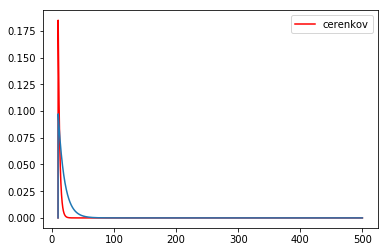

In [379]:
bot_left=Pulse(1000, -2,10)
t=np.arange(10,500,0.1)
plt.plot(t, bot_left.cerenkov_scaled(t), c='r', label="cerenkov")

plt.plot(t, bot_left.scintillation_normalized(t))
plt.legend()

bot_left.histogram_generator()

C:\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:595: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Text(0,0.5,'# of photoelectrons')

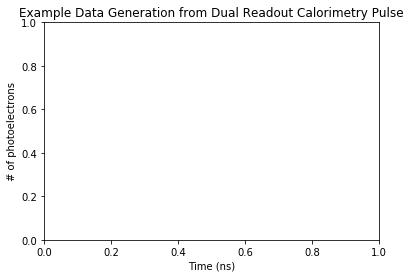

In [373]:
plt.figure()
vals=np.nan_to_num(bot_left.final_distribution())
vals=vals[vals<500]
plt.title("Example Data Generation from Dual Readout Calorimetry Pulse")
plt.xlabel("Time (ns)")
plt.ylabel("# of photoelectrons")

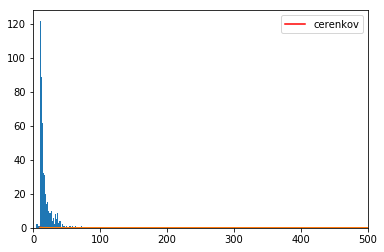

In [377]:
plt.hist(vals, bins=100)
plt.xlim(0,500)


In [211]:
bot_left=Pulse(1000,-100,2.5)
bot_right=Pulse(1000,-100,200)
top_left=Pulse(1000,100,2.5)
top_right=Pulse(1000,100,200)


Text(0,0.5,'Amplitude (Arbitrary Units)')

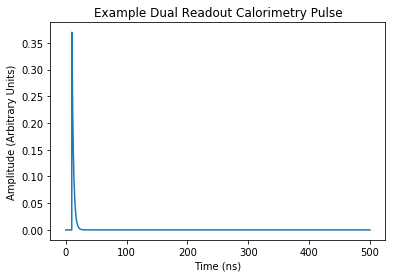

In [248]:
plt.plot(bot_left.t, bot_left.final_pdf(bot_left.t))
plt.title("Example Dual Readout Calorimetry Pulse")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (Arbitrary Units)")

Text(0,0.5,'Amplitude (Arbitrary Units)')

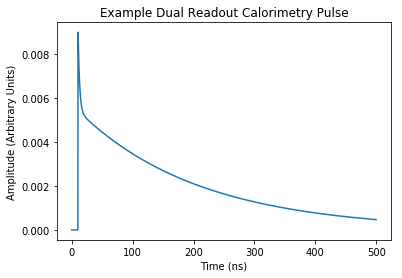

In [232]:
plt.plot(bot_right.t, bot_right.final_pdf(bot_right.t))
plt.title("Example Dual Readout Calorimetry Pulse")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (Arbitrary Units)")

In [233]:
a,b,c=bot_right.output()

Text(0,0.5,'# of photoelectrons')

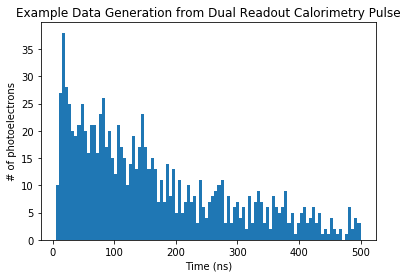

In [245]:
plt.hist(bot_right.final_distribution(),bins=100)
plt.title("Example Data Generation from Dual Readout Calorimetry Pulse")
plt.xlabel("Time (ns)")
plt.ylabel("# of photoelectrons")

Text(0,0.5,'Amplitude (Arbitrary Units)')

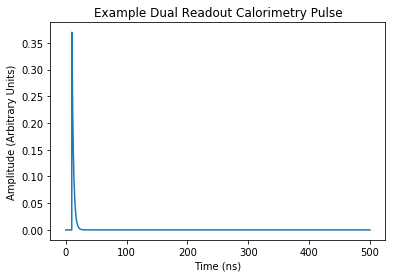

In [249]:
plt.plot(top_left.t, top_left.final_pdf(top_left.t))
plt.title("Example Dual Readout Calorimetry Pulse")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (Arbitrary Units)")

Text(0,0.5,'Amplitude (Arbitrary Units)')

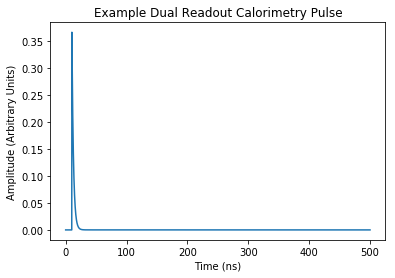

In [250]:
plt.plot(top_right.t, top_right.final_pdf(top_right.t))
plt.title("Example Dual Readout Calorimetry Pulse")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (Arbitrary Units)")

In [228]:
mid_right=Pulse(1000,50,200)

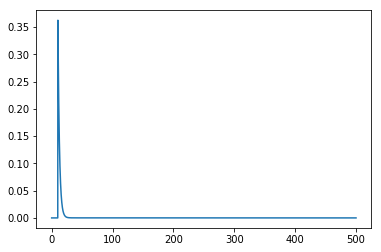

In [229]:
plt.plot(mid_right.t, mid_right.final_pdf(mid_right.t))

In [227]:
print(nn2_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 22        
Total params: 1,032
Trainable params: 1,032
Non-trainable params: 0
_________________________________________________________________
None


[-6.26176130e-01 -6.30829547e-03  4.88044139e-04  7.66944130e-03
  1.12582073e-02  1.06921944e-02 -6.27786465e-01 -7.03095230e-03
 -8.63269983e-03  4.39585260e-03  2.79189208e-03  6.40252096e-03
 -5.74779188e-01 -2.66840290e-02 -2.36770594e-02 -1.07030630e-02
 -7.40918065e-03 -1.12069052e-02  1.66548696e+00 -5.71091191e-01
 -5.63201199e-01 -5.81260081e-01 -5.72067805e-01 -5.72040842e-01
  1.87800832e+00  2.81977491e-01  2.66343783e-01  2.95648631e-01
  2.65071556e-01  2.62039107e-01  1.92249766e+00  1.07774362e+00
  7.97214958e-01  7.37306491e-01  7.61315710e-01  7.69754832e-01]
[-100. -100. -100. -100. -100. -100.  -60.  -60.  -60.  -60.  -60.  -60.
  -20.  -20.  -20.  -20.  -20.  -20.   20.   20.   20.   20.   20.   20.
   60.   60.   60.   60.   60.   60.  100.  100.  100.  100.  100.  100.]
[  2.5  42.   81.5 121.  160.5 200.    2.5  42.   81.5 121.  160.5 200.
   2.5  42.   81.5 121.  160.5 200.    2.5  42.   81.5 121.  160.5 200.
   2.5  42.   81.5 121.  160.5 200.    2.5  42.   

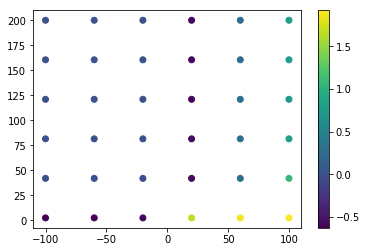

In [286]:
fig= plt.figure()
ax= fig.add_subplot(111)
print(nn2_profile_scintillation_mean_reordered.flatten())
x=[]
y=[]
nn2_scint_decays
for i in nn2_ratios:
    x.append([i]*6)

for i in range(6):
    y.append(nn2_scint_decays)

x=np.asarray(x)
y=np.asarray(y)
print(x.flatten())
print(y.flatten())
plot=ax.scatter(x.flatten(),y.flatten(), c=nn2_profile_scintillation_mean_reordered.flatten())
#amap=plt.cmap('coolwarm')
#plt.clabel(plot, plot.levels, inline=True,  fontsize=8)
plt.colorbar(plot)

[[-6.26176130e-01 -6.30829547e-03  4.88044139e-04  7.66944130e-03
   1.12582073e-02  1.06921944e-02]
 [-6.27786465e-01 -7.03095230e-03 -8.63269983e-03  4.39585260e-03
   2.79189208e-03  6.40252096e-03]
 [-5.74779188e-01 -2.66840290e-02 -2.36770594e-02 -1.07030630e-02
  -7.40918065e-03 -1.12069052e-02]
 [ 1.66548696e+00 -5.71091191e-01 -5.63201199e-01 -5.81260081e-01
  -5.72067805e-01 -5.72040842e-01]
 [ 1.87800832e+00  2.81977491e-01  2.66343783e-01  2.95648631e-01
   2.65071556e-01  2.62039107e-01]
 [ 1.92249766e+00  1.07774362e+00  7.97214958e-01  7.37306491e-01
   7.61315710e-01  7.69754832e-01]]


Text(0,0.5,'Photostatistics Ratio (C/S)')

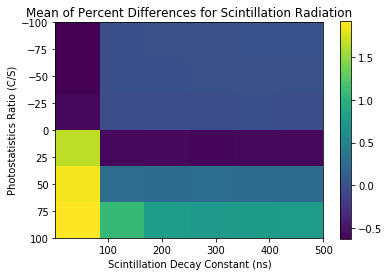

In [319]:
print(nn2_profile_scintillation_mean_reordered)
plt.imshow(nn2_profile_scintillation_mean_reordered, aspect=2,extent=(2.5, 500, 100, -100))
plt.colorbar()
plt.title("Mean of Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")

Text(0,0.5,'Photostatistics Ratio (C/S)')

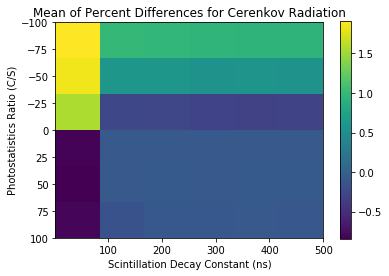

In [320]:
plt.imshow(nn2_profile_cerenkov_mean_reordered, aspect=2,extent=(2.5, 500, 100, -100))
plt.colorbar()
plt.title("Mean of Percent Differences for Cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")

Text(0,0.5,'Percent Difference')

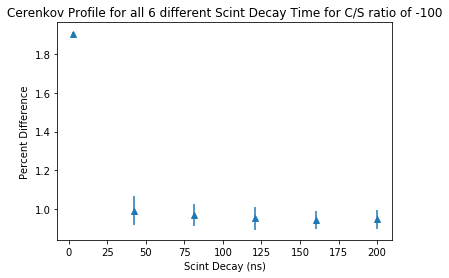

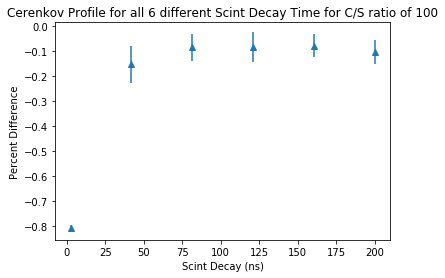

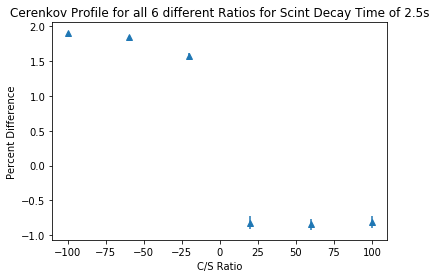

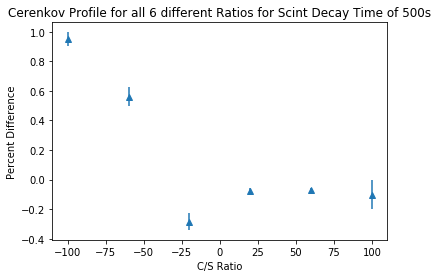

In [315]:
plt.errorbar(nn2_scint_decays,nn2_profile_cerenkov_mean_reordered[0], nn2_profile_cerenkov_stdev_reordered[0], linestyle='None', marker='^')
plt.title("Cerenkov Profile for all 6 different Scint Decay Time for C/S ratio of -100")
plt.xlabel("Scint Decay (ns)")
plt.ylabel("Percent Difference")

plt.figure()
plt.errorbar(nn2_scint_decays,nn2_profile_cerenkov_mean_reordered[-1], nn2_profile_cerenkov_stdev_reordered[0], linestyle='None', marker='^')
plt.title("Cerenkov Profile for all 6 different Scint Decay Time for C/S ratio of 100")
plt.xlabel("Scint Decay (ns)")
plt.ylabel("Percent Difference")

plt.figure()
plt.errorbar(nn2_ratios,[item[0] for item in nn2_profile_cerenkov_mean_reordered], [item[0] for item in nn2_profile_cerenkov_stdev_reordered], linestyle='None', marker='^')
plt.title("Cerenkov Profile for all 6 different Ratios for Scint Decay Time of 2.5s")
plt.xlabel("C/S Ratio")
plt.ylabel("Percent Difference")

plt.figure()
plt.errorbar(nn2_ratios,[item[-1] for item in nn2_profile_cerenkov_mean_reordered], [item[-1] for item in nn2_profile_cerenkov_stdev_reordered], linestyle='None', marker='^')
plt.title("Cerenkov Profile for all 6 different Ratios for Scint Decay Time of 500s")
plt.xlabel("C/S Ratio")
plt.ylabel("Percent Difference")

Text(0,0.5,'Percent Difference')

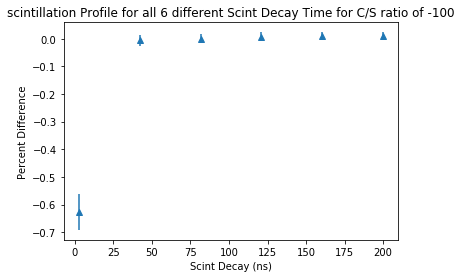

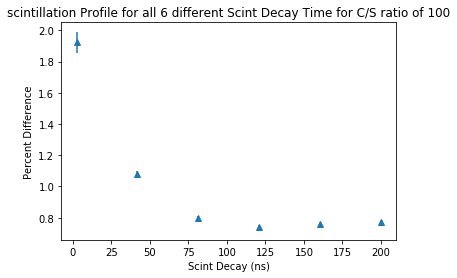

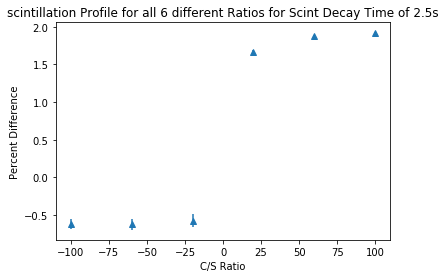

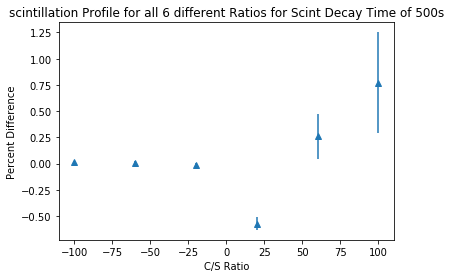

In [316]:
plt.errorbar(nn2_scint_decays,nn2_profile_scintillation_mean_reordered[0], nn2_profile_scintillation_stdev_reordered[0], linestyle='None', marker='^')
plt.title("scintillation Profile for all 6 different Scint Decay Time for C/S ratio of -100")
plt.xlabel("Scint Decay (ns)")
plt.ylabel("Percent Difference")

plt.figure()
plt.errorbar(nn2_scint_decays,nn2_profile_scintillation_mean_reordered[-1], nn2_profile_scintillation_stdev_reordered[0], linestyle='None', marker='^')
plt.title("scintillation Profile for all 6 different Scint Decay Time for C/S ratio of 100")
plt.xlabel("Scint Decay (ns)")
plt.ylabel("Percent Difference")

plt.figure()
plt.errorbar(nn2_ratios,[item[0] for item in nn2_profile_scintillation_mean_reordered], [item[0] for item in nn2_profile_scintillation_stdev_reordered], linestyle='None', marker='^')
plt.title("scintillation Profile for all 6 different Ratios for Scint Decay Time of 2.5s")
plt.xlabel("C/S Ratio")
plt.ylabel("Percent Difference")

plt.figure()
plt.errorbar(nn2_ratios,[item[-1] for item in nn2_profile_scintillation_mean_reordered], [item[-1] for item in nn2_profile_scintillation_stdev_reordered], linestyle='None', marker='^')
plt.title("scintillation Profile for all 6 different Ratios for Scint Decay Time of 500s")
plt.xlabel("C/S Ratio")
plt.ylabel("Percent Difference")

In [318]:
print(nn2_profile_cerenkov_mean_reordered[0])
nn2_profile_labels_clean_check[0]

[1.90428117 0.99138836 0.97086148 0.95258322 0.94462941 0.94810133]


['ratio0.01scintdecay2.5',
 'ratio0.01scintdecay42.0',
 'ratio0.01scintdecay81.5',
 'ratio0.01scintdecay121.0',
 'ratio0.01scintdecay160.5',
 'ratio0.01scintdecay200.0']